<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/ODR(Normal%2C_Cataract%2C_Diabetes%2C_and_Glaucoma)_using_different_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
! unzip ocular-disease-recognition-odir5k

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [155]:
#Importing libraries
import os
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [156]:
dataset = pd.read_csv('/content/full_df.csv')

In [157]:
dataset.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
dataset.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

<Axes: xlabel='labels', ylabel='count'>

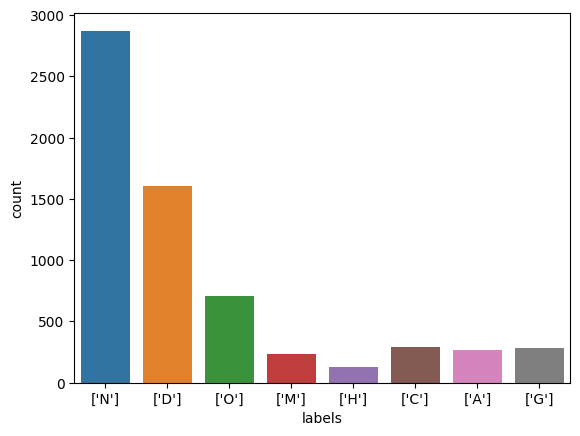

In [ ]:
sns.countplot(x = dataset['labels'], data = dataset)

<Axes: xlabel='Patient Sex', ylabel='count'>

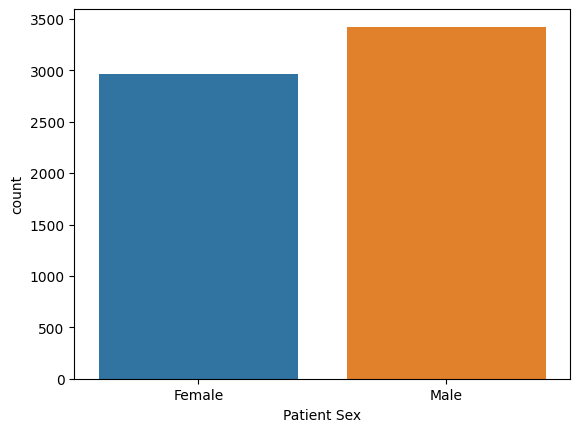

In [ ]:
sns.countplot(x = dataset['Patient Sex'], data = dataset)

(array([2968.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3424.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

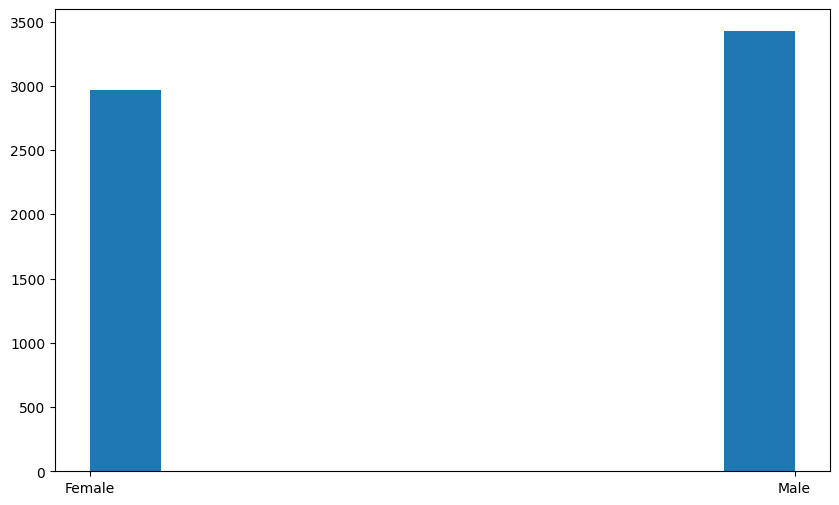

In [ ]:
plt.figure(figsize = (10, 6))
plt.hist(dataset['Patient Sex'])

(array([  28.,    8.,   29.,  223.,  589., 1378., 2057., 1511.,  486.,
          83.]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <BarContainer object of 10 artists>)

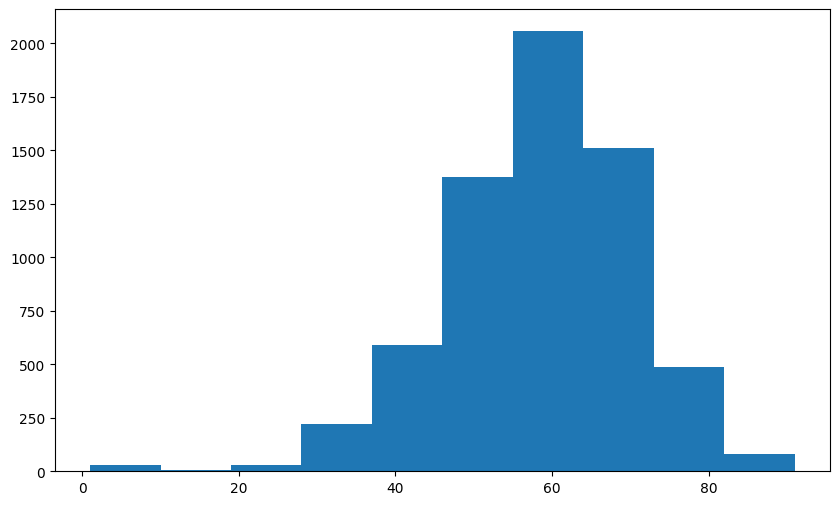

In [ ]:
plt.figure(figsize = (10, 6))
plt.hist(dataset['Patient Age'])

**Extracting definitive diagnosis per patient...**

In [ ]:
dataset['Left-Diagnostic Keywords'].unique()

array(['cataract', 'normal fundus',
       'laser spot，moderate non proliferative retinopathy',
       'macular epiretinal membrane',
       'moderate non proliferative retinopathy', 'drusen',
       'epiretinal membrane',
       'moderate non proliferative retinopathy，hypertensive retinopathy',
       'pathological myopia', 'mild nonproliferative retinopathy',
       'hypertensive retinopathy',
       'macular epiretinal membrane，mild nonproliferative retinopathy',
       'macular hole', 'wet age-related macular degeneration',
       'moderate non proliferative retinopathy，laser spot',
       'moderate non proliferative retinopathy，myelinated nerve fibers',
       'dry age-related macular degeneration',
       'epiretinal membrane，myelinated nerve fibers',
       'diabetic retinopathy', 'epiretinal membrane，lens dust', 'atrophy',
       'laser spot，white vessel，moderate non proliferative retinopathy',
       'chorioretinal atrophy',
       'moderate non proliferative retinopathy，catar

**In our dataset, we used 4 classes:**
- - Normal
- - Glaucoma
- - Cataract
- - Diabetic Retinopathy
     - mild nonproliferative retinopathy
     - proliferative retinopathy
     - diabetic retinopathy
     - moderate non proliferative retinopathy

In [158]:
def has_cataract(text):
    if "cataract" in text:
        return 2
    else:
        return 0

dataset['left_cataract'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_cataract(x))
dataset['right_cataract'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_cataract(x))

left_cataract = dataset.loc[(dataset.C == 1) & (dataset['left_cataract'] == 2)]['Left-Fundus'].values
right_cataract = dataset.loc[(dataset.C == 1) & (dataset['right_cataract'] == 2)]['Right-Fundus'].values
cataract = np.concatenate((left_cataract, right_cataract), axis=0)

In [159]:
def has_normal_fundus(text):
    if "normal fundus" in text:
        return 1
    else:
        return 0

dataset['left_normal'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))
dataset['right_normal'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))

left_normal = dataset.loc[(dataset.N == 1) & (dataset['left_normal'] == 1)]["Left-Fundus"].values
right_normal = dataset.loc[(dataset.N == 1) & (dataset["right_normal"] == 1)]["Right-Fundus"].values
normal = np.concatenate((left_normal, right_normal), axis=0)

In [160]:
def has_retinopathy(text):
  if ('mild nonproliferative retinopathy') or ('proliferative retinopathy') or ('diabetic retinopathy') or ('moderate non proliferative retinopathy') in text:
    return 3
  else:
    return 0

dataset['left_diabetes'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))
dataset['right_diabetes'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))

left_diabetes = dataset.loc[(dataset.D == 1) & (dataset['left_diabetes'] == 3)]['Left-Fundus'].values
right_diabetes = dataset.loc[(dataset.D == 1) & (dataset['right_diabetes'] == 3)]['Right-Fundus'].values
diabetes = np.concatenate((left_diabetes, right_diabetes), axis=0)

In [161]:
def has_glaucoma(text):
  if 'glaucoma' in text:
    return 4
  else:
    return 0

dataset['left_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))
dataset['right_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))

left_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['left_glaucoma'] == 4)]['Left-Fundus'].values
right_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['right_glaucoma'] == 4)]['Right-Fundus'].values
glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis=0)

In [162]:
print("Cataract : ", len(cataract))
print("Normal : ", len(normal))
print("Glaucoma : ", len(glaucoma))
print("Diabetes : ", len(diabetes))

Cataract :  594
Normal :  4201
Glaucoma :  664
Diabetes :  4246


In [163]:
dataset_dir = '/content/preprocessed_images'
image_size = 224
labels = []
new_dataset = []
def create_dataset(image_category, label):
  for img in tqdm(image_category):
    image_path = os.path.join(dataset_dir, img)
    try:
      image = cv.imread(image_path, cv.IMREAD_COLOR)
      image = cv.resize(image, (image_size, image_size))
    except:
      continue

    new_dataset.append([np.array(image), np.array(label)])
  random.shuffle(new_dataset)
  return new_dataset

In [164]:
new_dataset = create_dataset(cataract, 1)
new_dataset = create_dataset(glaucoma, 3)
new_dataset = create_dataset(normal, 0)
new_dataset = create_dataset(diabetes, 2)

100%|██████████| 4246/4246 [00:18<00:00, 235.02it/s]


In [165]:
print("New dataset length : ", len(new_dataset))

New dataset length :  9544


In [ ]:
new_dataset[0][0].shape

(224, 224, 3)

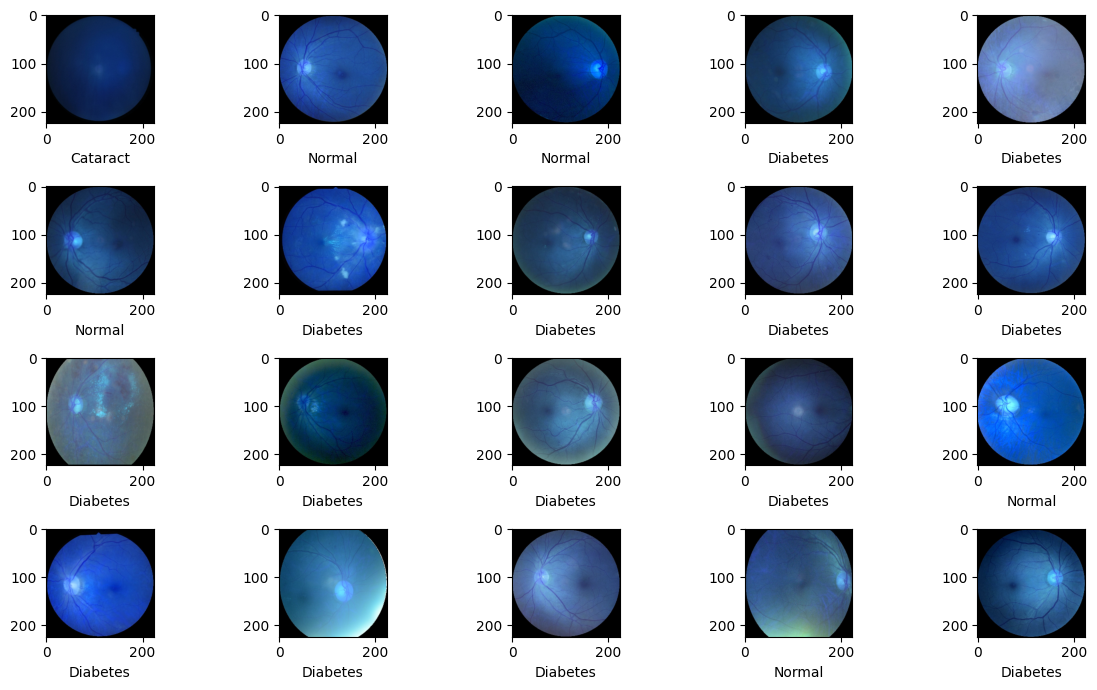

In [ ]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(new_dataset)))
    image = new_dataset[sample][0]
    label = new_dataset[sample][1]
    if label == 0:
      label = "Normal"
    elif label == 1:
      label = "Cataract"
    elif label == 2:
      label = "Diabetes"
    elif label == 3:
      label = "Glaucoma"
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

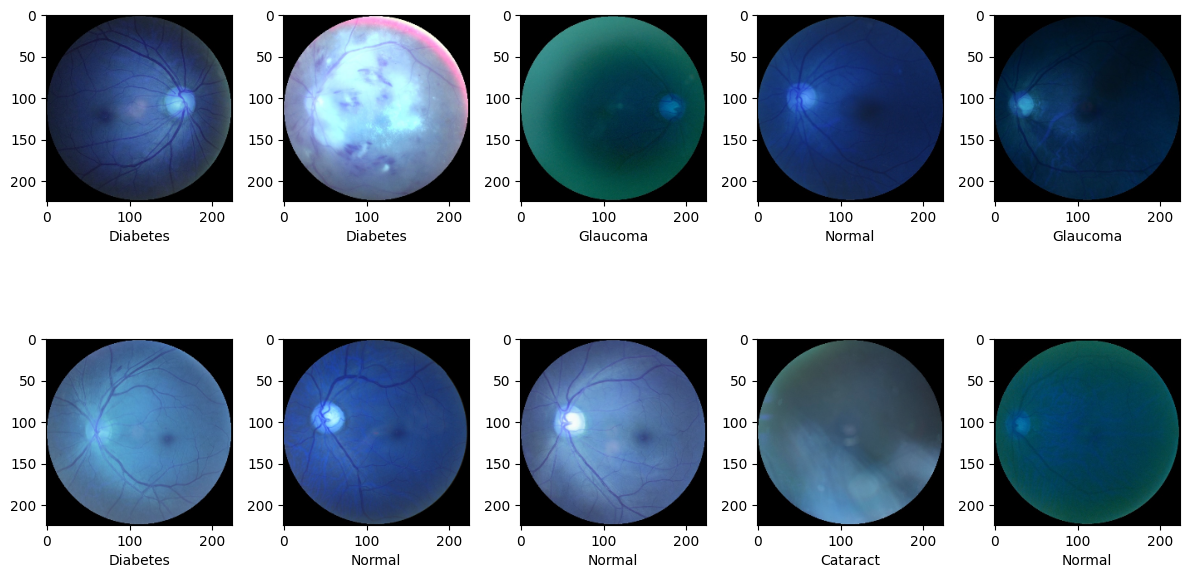

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(new_dataset)))
    image = new_dataset[sample][0]
    label = new_dataset[sample][1]
    if label == 0:
      label = "Normal"
    elif label == 1:
      label = "Cataract"
    elif label == 2:
      label = "Diabetes"
    elif label == 3:
      label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
# Because of the way the labels were created, it's better to categorize them to prevent deceiving the model
x = np.array([i[0] for i in new_dataset]).reshape(-1,image_size,image_size,3)
y = to_categorical([i[1] for i in new_dataset])

In [ ]:
# Splitting the dataset into train, validation and test sets
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(x,y,test_size=0.2)
X_val,X_test,Y_val,Y_test = train_test_split(X_val, Y_val, test_size=0.5)

In [ ]:
print(len(X_train), len(X_val), len(Y_train), len(Y_val))

7635 954 7635 954


In [ ]:
print(len(X_val), len(X_test), len(Y_val), len(Y_test))

954 955 954 955


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(7635, 224, 224, 3)
(955, 224, 224, 3)
(954, 224, 224, 3)
(7635, 4)
(955, 4)
(954, 4)


## **VGG16**

In [ ]:
# Importing a trained model.

from tensorflow.keras.applications.vgg16 import VGG16
vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape= (224,224,3)
)
vgg.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
x = Flatten()(vgg.output)
dense1 = Dense(units=128,activation='relu')(x)
dense2 = Dense(units=128, activation='relu')(dense1)
output = Dense(units=4, activation='softmax')(dense2)
A = Model(inputs = vgg.input, outputs = output)
A.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate = 0.00001)
A.compile(optimizer= optim, loss= 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
training = A.fit(x=X_train, y=Y_train, batch_size=128, epochs=20, validation_data=(X_val, Y_val))

Epoch 1/20
60/60 [==============================] - 82s 971ms/step - loss: 2.1138 - accuracy: 0.4633 - val_loss: 1.5238 - val_accuracy: 0.4990
Epoch 2/20
60/60 [==============================] - 34s 563ms/step - loss: 1.2641 - accuracy: 0.5460 - val_loss: 1.2353 - val_accuracy: 0.5367
Epoch 3/20
60/60 [==============================] - 36s 598ms/step - loss: 0.9864 - accuracy: 0.6056 - val_loss: 1.0772 - val_accuracy: 0.5702
Epoch 4/20
60/60 [==============================] - 34s 572ms/step - loss: 0.8134 - accuracy: 0.6663 - val_loss: 0.9776 - val_accuracy: 0.6080
Epoch 5/20
60/60 [==============================] - 35s 591ms/step - loss: 0.6868 - accuracy: 0.7175 - val_loss: 0.8959 - val_accuracy: 0.6352
Epoch 6/20
60/60 [==============================] - 34s 575ms/step - loss: 0.5865 - accuracy: 0.7589 - val_loss: 0.8420 - val_accuracy: 0.6457
Epoch 7/20
60/60 [==============================] - 36s 595ms/step - loss: 0.5078 - accuracy: 0.7962 - val_loss: 0.7787 - val_accuracy: 0.6740

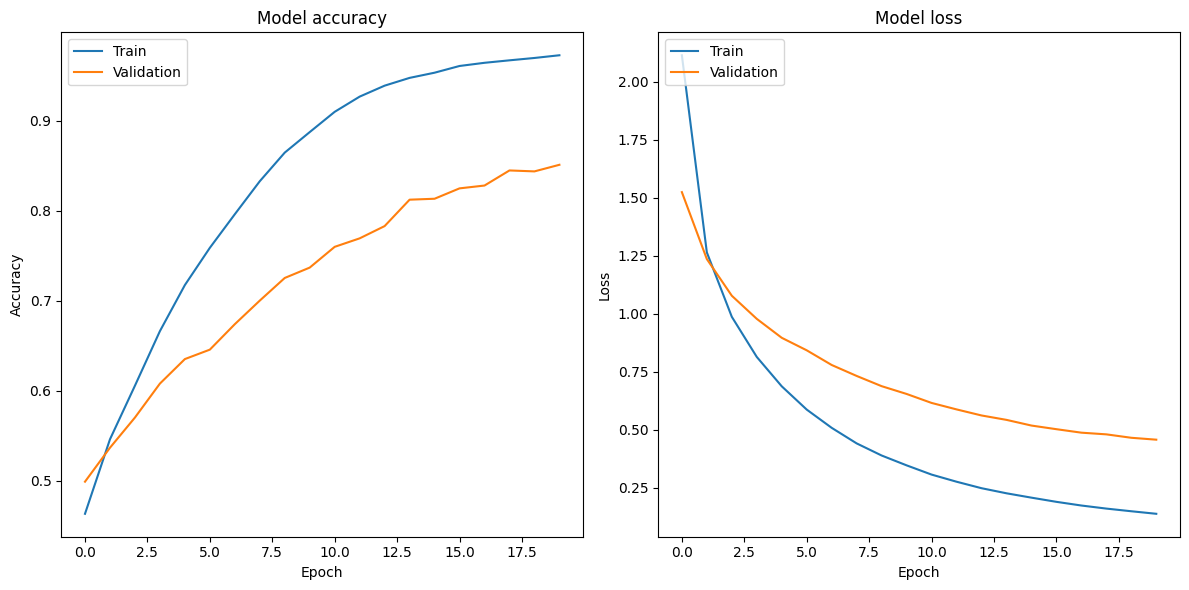

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
accuracy = A.evaluate(X_test, Y_test)

30/30 [==============================] - 12s 261ms/step - loss: 0.4469 - accuracy: 0.8670


In [ ]:
Y_pred = A.predict(X_test)
print(Y_pred)

30/30 [==============================] - 4s 125ms/step
[[5.4635984e-01 7.0852633e-07 4.4884360e-01 4.7958558e-03]
 [8.5931569e-02 3.2979457e-03 9.1074836e-01 2.2138569e-05]
 [9.9680650e-01 3.0731303e-06 1.9914569e-06 3.1884906e-03]
 ...
 [9.9465162e-01 1.5659865e-03 3.7359204e-03 4.6541838e-05]
 [8.5170960e-01 1.6707915e-03 1.4343490e-01 3.1847146e-03]
 [8.5742265e-01 1.0663695e-04 1.9666171e-02 1.2280460e-01]]


In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

In [ ]:
Y_test

array([0, 2, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 3, 0, 0, 2, 0, 2, 3, 2,
       0, 1, 2, 0, 3, 1, 0, 3, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 3, 0, 1, 2, 0, 2, 2, 0, 0, 2,
       2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 1, 2, 2, 2,
       2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 0, 3, 0, 0, 1, 0, 1,
       2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0,
       0, 2, 2, 0, 2, 0, 0, 2, 3, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0,
       0, 2, 2, 1, 0, 3, 0, 2, 2, 0, 2, 2, 2, 0, 2, 3, 0, 2, 2, 3, 0, 1,
       2, 2, 0, 1, 3, 1, 2, 0, 2, 2, 0, 0, 2, 3, 2, 2, 2, 0, 0, 3, 2, 0,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       2, 2, 2, 0, 2, 0, 1, 0, 0, 2, 1, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 0,
       2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 3, 2, 0, 2, 2, 2, 0, 3, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 0, 3, 3, 2, 2, 2, 2, 0,

In [ ]:
Y_pred

array([0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 2, 3, 2,
       0, 1, 2, 0, 3, 1, 0, 3, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 0, 1, 2, 0, 2, 2, 0, 0, 2,
       2, 0, 1, 1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 2, 0, 0, 2, 2, 2,
       0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 2, 1, 0, 3, 0, 0, 1, 0, 1,
       2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0,
       2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0,
       0, 0, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 2, 0, 2, 2, 0, 1, 2, 0, 0, 1,
       2, 2, 0, 2, 3, 1, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2, 2, 0, 0, 3, 2, 0,
       0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 3, 0, 2, 0, 2, 0, 3, 0, 0, 0, 0,
       2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 0,
       2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 3, 2, 0, 0,
       2, 1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0,

**Checking model performance**

In [ ]:
cm = confusion_matrix(Y_test, Y_pred, labels= [0,1,2,3])

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.92344498 0.         0.06698565 0.00956938]
 [0.06060606 0.75757576 0.12121212 0.06060606]
 [0.0982801  0.02702703 0.84520885 0.02948403]
 [0.109375   0.015625   0.125      0.75      ]]


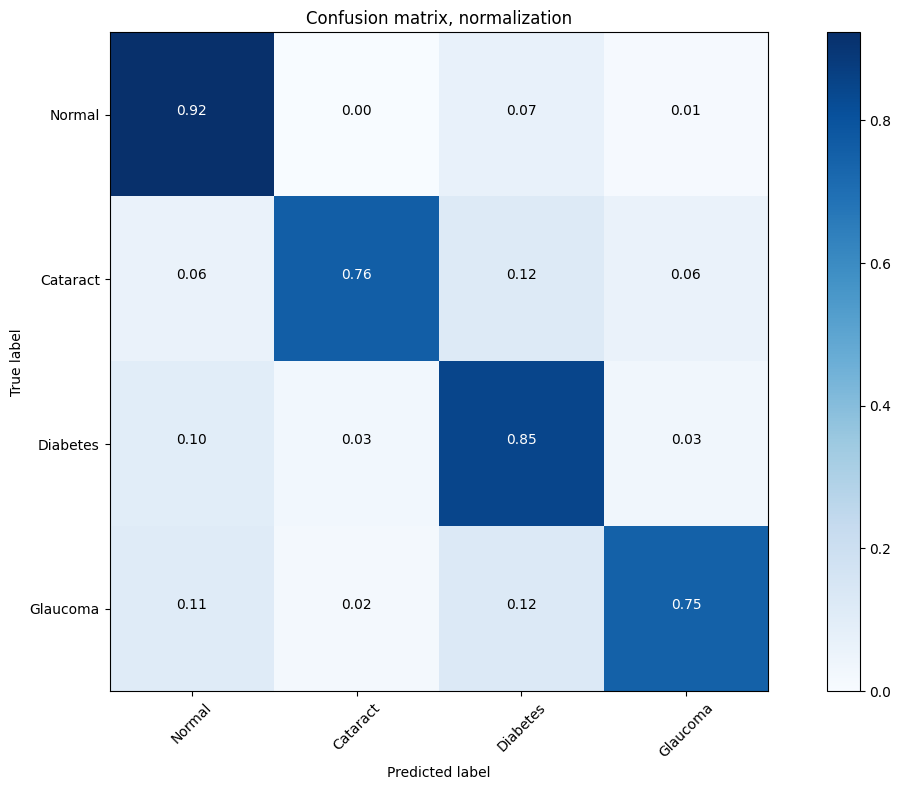

In [ ]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm, classes=['Normal', 'Cataract', 'Diabetes', 'Glaucoma'], title='Confusion matrix, normalization')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma']))

              precision    recall  f1-score   support

      Normal       0.88      0.92      0.90       418
    Cataract       0.81      0.76      0.78        66
    Diabetes       0.89      0.85      0.87       407
    Glaucoma       0.71      0.75      0.73        64

    accuracy                           0.87       955
   macro avg       0.82      0.82      0.82       955
weighted avg       0.87      0.87      0.87       955



In [ ]:
accuracy_score(Y_test, Y_pred, normalize=True)

0.8670157068062827

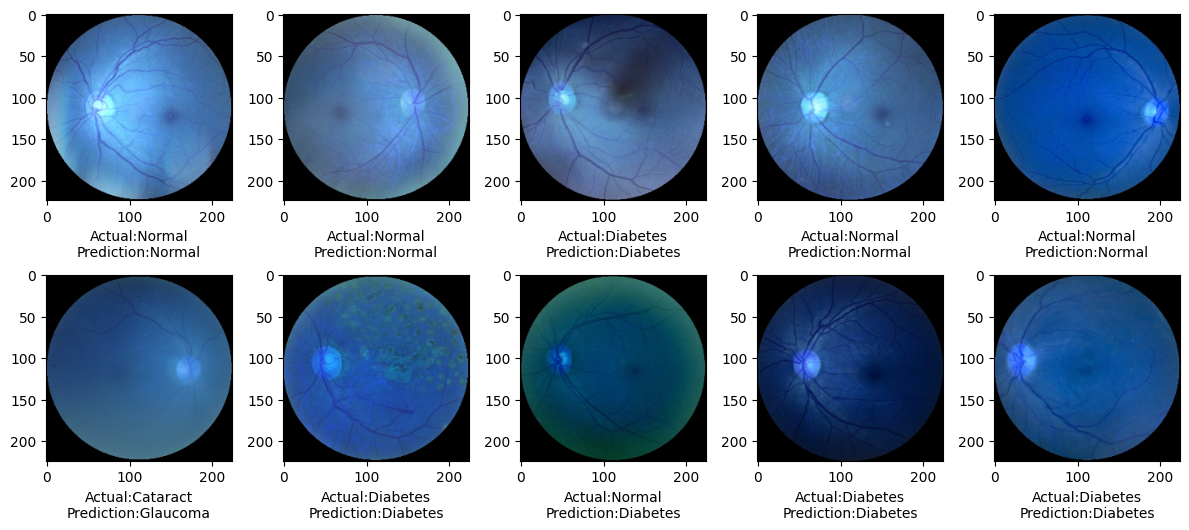

In [ ]:
plt.figure(figsize=(12,10))
for i in range(10):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = Y_test[sample]
    pred_category = Y_pred[sample]

    if category== 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"

    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1:
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"

    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

**Trying out model on completely new image loaded from system...**

In [ ]:
#Loading in new image

new_image = cv.imread('/content/test_image.png')
new_image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)
new_image = cv.resize(new_image, (224, 224))

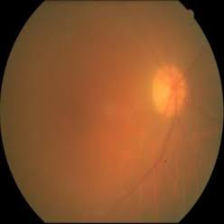

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(new_image)

In [ ]:
# Running model on new image

copy_new_image = np.array(new_image).reshape(-1,224,224,3)
new_prediction = A.predict(copy_new_image)

1/1 [==============================] - 1s 658ms/step


In [ ]:
np = np.argmax(new_prediction, axis=1)

In [ ]:
# Printing out prediction
np

array([2])

In [ ]:
target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma']

In [ ]:
target_names[np[0]]

'Diabetes'

## **ResNet50**

In [140]:
import numpy as np
import pandas as pd
import cv2 #It's a library that provides functions for computer vision tasks, such as image processing, feature extraction, and object detection.
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [141]:
dataset = pd.read_csv('/content/full_df.csv')

In [142]:
dataset.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [143]:
len(dataset)

6392

In [144]:
dataset.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [146]:
def has_cataract(text):
    if "cataract" in text:
        return 2
    else:
        return 0

dataset['left_cataract'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_cataract(x))
dataset['right_cataract'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_cataract(x))

left_cataract = dataset.loc[(dataset.C == 1) & (dataset['left_cataract'] == 2)]['Left-Fundus'].values
right_cataract = dataset.loc[(dataset.C == 1) & (dataset['right_cataract'] == 2)]['Right-Fundus'].values
cataract = np.concatenate((left_cataract, right_cataract), axis=0)

In [147]:
def has_normal_fundus(text):
    if "normal fundus" in text:
        return 1
    else:
        return 0

dataset['left_normal'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))
dataset['right_normal'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))

left_normal = dataset.loc[(dataset.N == 1) & (dataset['left_normal'] == 1)]["Left-Fundus"].values
right_normal = dataset.loc[(dataset.N == 1) & (dataset["right_normal"] == 1)]["Right-Fundus"].values
normal = np.concatenate((left_normal, right_normal), axis=0)

In [148]:
def has_retinopathy(text):
  if ('mild nonproliferative retinopathy') or ('proliferative retinopathy') or ('diabetic retinopathy') or ('moderate non proliferative retinopathy') in text:
    return 3
  else:
    return 0

dataset['left_diabetes'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))
dataset['right_diabetes'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))

left_diabetes = dataset.loc[(dataset.D == 1) & (dataset['left_diabetes'] == 3)]['Left-Fundus'].values
right_diabetes = dataset.loc[(dataset.D == 1) & (dataset['right_diabetes'] == 3)]['Right-Fundus'].values
diabetes = np.concatenate((left_diabetes, right_diabetes), axis=0)

In [149]:
def has_glaucoma(text):
  if 'glaucoma' in text:
    return 4
  else:
    return 0

dataset['left_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))
dataset['right_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))

left_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['left_glaucoma'] == 4)]['Left-Fundus'].values
right_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['right_glaucoma'] == 4)]['Right-Fundus'].values
glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis=0)

In [150]:
print("Cataract : ", len(cataract))
print("Normal : ", len(normal))
print("Glaucoma : ", len(glaucoma))
print("Diabetes : ", len(diabetes))

Cataract :  594
Normal :  4201
Glaucoma :  664
Diabetes :  4246


In [151]:
import os
dataset_dir = '/content/preprocessed_images'
image_size = 224
labels = []
new_dataset = []
def create_dataset(image_category, label):
  for img in tqdm(image_category):
    image_path = os.path.join(dataset_dir, img)
    try:
      image = cv.imread(image_path, cv.IMREAD_COLOR)
      image = cv.resize(image, (image_size, image_size))
    except:
      continue

    new_dataset.append([np.array(image), np.array(label)])
  random.shuffle(new_dataset)
  return new_dataset

In [152]:
new_dataset = create_dataset(cataract, 1)
new_dataset = create_dataset(glaucoma, 3)
new_dataset = create_dataset(normal, 0)
new_dataset = create_dataset(diabetes, 2)

100%|██████████| 4246/4246 [00:00<00:00, 327980.53it/s]


In [166]:
print("New dataset length : ", len(new_dataset))

New dataset length :  9544


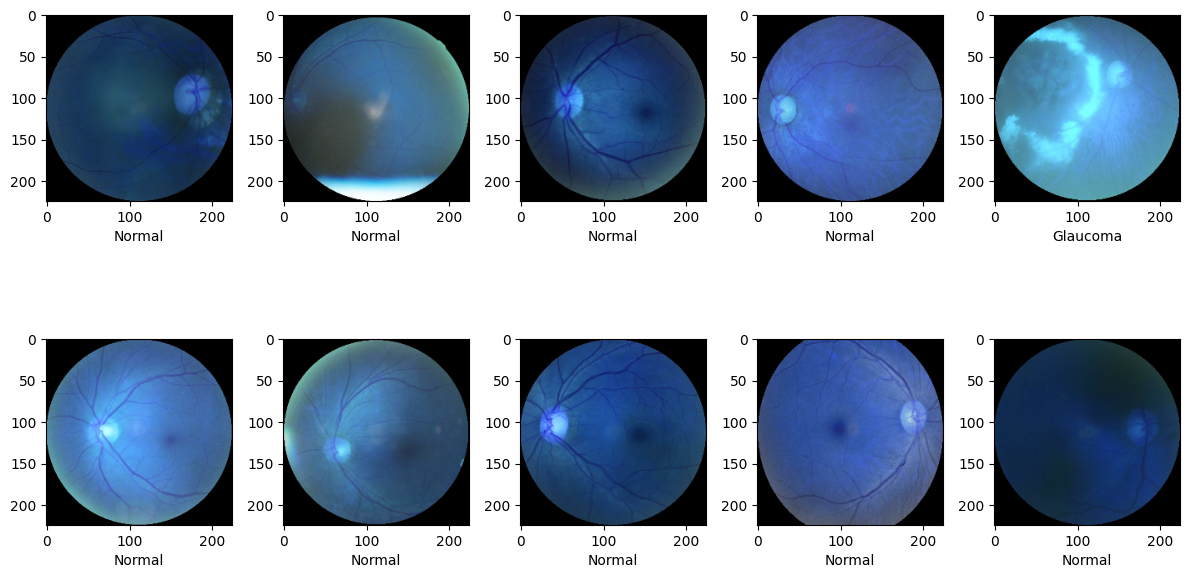

In [167]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(new_dataset)))
    image = new_dataset[sample][0]
    label = new_dataset[sample][1]
    if label == 0:
      label = "Normal"
    elif label == 1:
      label = "Cataract"
    elif label == 2:
      label = "Diabetes"
    elif label == 3:
      label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

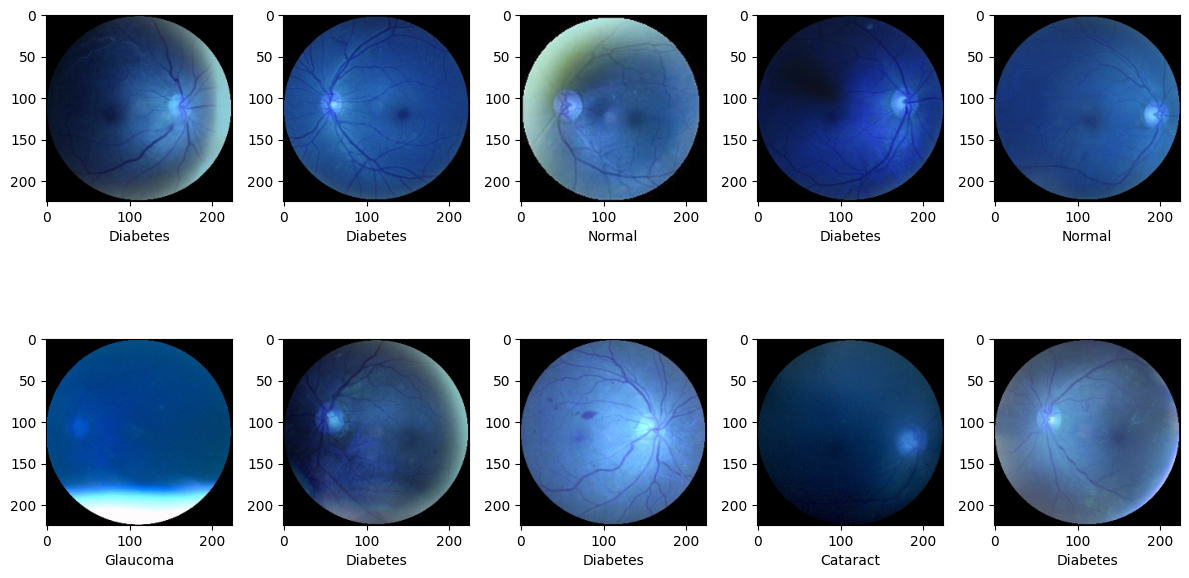

In [168]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(new_dataset)))
    image = new_dataset[sample][0]
    label = new_dataset[sample][1]
    if label == 0:
      label = "Normal"
    elif label == 1:
      label = "Cataract"
    elif label == 2:
      label = "Diabetes"
    elif label == 3:
      label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [169]:
# Because of the way the labels were created, it's better to categorize them to prevent deceiving the model
x = np.array([i[0] for i in new_dataset]).reshape(-1,image_size,image_size,3)
y = to_categorical([i[1] for i in new_dataset])

In [170]:
# Splitting the dataset into train, validation and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [171]:
print(len(x_train), len(x_test), len(y_train), len(y_test))

7635 1909 7635 1909


In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Load the pre-trained ResNet-50 model with ImageNet weights
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (image_size,image_size,3))
base_model.save('model_name.h5')

from tensorflow.keras.models import load_model
resnet = load_model('model_name.h5')

# Create a new model based on ResNet-50
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

#Define callbacks
checkpoint = ModelCheckpoint("ResNet50.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, period=1)
earlystop = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint, earlystop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 49,225,988
Non-trainable params: 53,120
_________________________________________________________________


Epoch 1/20
